In [1]:
exp_name = 'dpl_001'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from multiprocessing import Process, Queue

In [4]:
import pickle
import csv
import os
import time
import datetime
import lmdb

In [5]:
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)

now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
logfile = open(f'../../log/{exp_name}.txt', 'a')
logfile.write(f'\n\n\n\n ----------------- {now} ----------------- \n\n')
logfile.flush()
def log(string, stdout=True):
    if stdout:
        print(string)
    logfile.write(string + '\n')
    logfile.flush()

In [6]:
with open('../../metadata/200_handpicked_labels.csv', 'r') as fin:
    all_labels = [item.strip() for item in fin]
    
label2idx = {}
for i, l in enumerate(all_labels):
    label2idx[l] = i
    

In [7]:
with open('../../../data/seedling/jpg.txt', 'r') as fin:
    test_img_filenames = [line.strip() for line in fin]
test_img_filenames = ['../../../data/seedling/' + item for item in test_img_filenames]

In [8]:
resnet = torchvision.models.resnet50() # resnet.eval() is very important, do not forget this line during testing!
print(resnet.fc)
resnet.fc = nn.Linear(2048, len(all_labels))
#saved_state_dict = torch.load(os.path.join('data/snapshots/','d2_rel_open_1600.pth'))
saved_state_dict = torch.load(os.path.join('../../snapshots', 'train_010', 'ckpt_4000'))
resnet.load_state_dict(saved_state_dict)
resnet.cuda(0)
resnet.eval()
resnet.float()

Linear(in_features=2048, out_features=1000, bias=True)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [9]:
finalconv_name = 'layer4'

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

resnet._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(resnet.parameters())
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [10]:
def get_bbox(fid):
    bbox_threshold = [20, 100, 110]
    curParaThreshold = str(bbox_threshold[0]) + ' ' + str(bbox_threshold[1]) + ' ' + str(bbox_threshold[2])
    curHeatMapFile = f'../../CAM/bboxgenerator/heatmap_{fid}.jpg'
    # curImgFile = 'sample_6.jpg'
    curBBoxFile = f'../../CAM/bboxgenerator/heatmap_{fid}.txt'
    cmd = '../../CAM/bboxgenerator/./dt_box ' + curHeatMapFile + ' ' + curParaThreshold + ' ' + curBBoxFile
    if os.path.isfile(curBBoxFile):
        os.remove(curBBoxFile)
    os.system(cmd)
    lines = open(curBBoxFile).readlines()
    boxData = np.asarray(lines[0].split(),dtype= float)
    a = boxData[0::4]
    b = boxData[1::4]
    c = boxData[0::4] + boxData[2::4]
    d = boxData[1::4]+ boxData[3::4]
    boxData_formulate = np.vstack((a,b,c,d)).T
    a = np.minimum(boxData_formulate[:,0],boxData_formulate[:,2])
    b = np.minimum(boxData_formulate[:,1],boxData_formulate[:,3])
    c = np.maximum(boxData_formulate[:,0],boxData_formulate[:,2])
    d = np.maximum(boxData_formulate[:,1],boxData_formulate[:,3])
    boxData_formulate = np.vstack((a,b,c,d)).T
    return boxData_formulate

In [11]:
q_cam = Queue()
q_bbox = Queue()

In [12]:
def fn(pid):
    while(True):
        item = q_cam.get()    
        if item == 'DONE':
            q_bbox.put('DONE')
            return
        key, CAMs = item
        topk_box = []
        for iii in range(len(CAMs)):
            heat_resized = cv2.resize(CAMs[iii],(224, 224))
            cv2.imwrite(f'../../CAM/bboxgenerator/heatmap_{pid}.jpg', heat_resized)
            bbox = get_bbox(pid)
            bbox = bbox.astype('float32') / 224.0
            topk_box.append(bbox)

        q_bbox.put((key, topk_box))
            
    

In [13]:
proc = []
n_proc = 20
for i in range(n_proc):
    proc.append(Process(target=fn, args=(i,)))

In [14]:
for p in proc:
    p.start()

In [15]:
batch_size = 100
det_results = {}
batch = []
batch_keys = []
for i, filename in enumerate(test_img_filenames):
    try:
        with open(filename, 'rb') as fin:
            _ = fin.read(1024)
            imgbin = fin.read()
        imgbgr = cv2.imdecode(np.fromstring(imgbin, dtype='uint8'), cv2.IMREAD_COLOR)
        imgbgr = cv2.resize(imgbgr, (224, 224))
        imgrgb = imgbgr[:,:,[2,1,0]]        
        assert(imgrgb.shape[0] == 224 and imgrgb.shape[1] == 224 and imgrgb.shape[2] == 3)
    except Exception as ex:
        log(str(ex))
        continue
    
    imgrgb = imgrgb.astype(float)/255.0
    
    imgrgb[:,:,0] = (imgrgb[:,:,0] - 0.485)/0.229
    imgrgb[:,:,1] = (imgrgb[:,:,1] - 0.456)/0.224
    imgrgb[:,:,2] = (imgrgb[:,:,2] - 0.406)/0.225

    imgrgb = imgrgb.transpose((2,0,1))
    batch.append(imgrgb)
    imgid = filename.split('/')[-1]
    batch_keys.append(imgid)
    
    if len(batch) == batch_size or (i + 1) == len(test_img_filenames):
        batch = np.stack(batch)
    
        features_blobs = []
        
        with torch.no_grad():
            inp = torch.from_numpy(batch).float().cuda(0)
            outputs = resnet(inp)
            h_x = F.softmax(outputs).data.squeeze()
            probs, idx = h_x.sort(1, True)
            idx = np.asarray(idx)
            probs = np.asarray(probs)
        
        for ii in range(len(batch_keys)):            
            CAMs = returnCAM(features_blobs[0][ii:ii+1], weight_softmax, list(idx[ii]))
            q_cam.put((batch_keys[ii], CAMs))
            det_results[batch_keys[ii]] = {
                'sorted_labels': idx[ii],
                'sorted_probs': probs[ii],                
            }

        
        batch = []
        batch_keys = []
        log(f'processed {i + 1} out of {len(test_img_filenames)} images.')

/home/alireza/home_at_filer2/tools/anaconda3/envs/py3torch/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/alireza/home_at_filer2/tools/anaconda3/envs/py3torch/lib/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


processed 100 out of 3691 images.
processed 200 out of 3691 images.
processed 300 out of 3691 images.
processed 400 out of 3691 images.
processed 500 out of 3691 images.
processed 600 out of 3691 images.
processed 700 out of 3691 images.
processed 800 out of 3691 images.
processed 900 out of 3691 images.
processed 1000 out of 3691 images.
processed 1100 out of 3691 images.
processed 1200 out of 3691 images.
processed 1300 out of 3691 images.
processed 1400 out of 3691 images.
processed 1500 out of 3691 images.
processed 1600 out of 3691 images.
processed 1700 out of 3691 images.
processed 1800 out of 3691 images.
OpenCV(3.4.1) /io/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215) ssize.width > 0 && ssize.height > 0 in function resize

processed 1901 out of 3691 images.
processed 2001 out of 3691 images.
processed 2101 out of 3691 images.
processed 2201 out of 3691 images.
processed 2301 out of 3691 images.
processed 2401 out of 3691 images.
processed 2501 out of 3691 images.
pr

In [16]:
for _ in range(n_proc):
    q_cam.put('DONE')

In [17]:
cnt = 0
n_done = 0
while(n_done < n_proc):
    item = q_bbox.get()
    if item == 'DONE':
        n_done += 1
        continue
    key, topk_bbox = item
    det_results[key]['sorted_bboxes'] = topk_bbox
    if cnt % 100 == 0:
        print(f'collected {cnt} out pf {len(test_img_filenames)} results from the queue')
    cnt += 1
for p in proc:
    p.join()        

collected 0 out pf 3691 results from the queue
collected 100 out pf 3691 results from the queue
collected 200 out pf 3691 results from the queue
collected 300 out pf 3691 results from the queue
collected 400 out pf 3691 results from the queue
collected 500 out pf 3691 results from the queue
collected 600 out pf 3691 results from the queue
collected 700 out pf 3691 results from the queue
collected 800 out pf 3691 results from the queue
collected 900 out pf 3691 results from the queue
collected 1000 out pf 3691 results from the queue
collected 1100 out pf 3691 results from the queue
collected 1200 out pf 3691 results from the queue
collected 1300 out pf 3691 results from the queue
collected 1400 out pf 3691 results from the queue
collected 1500 out pf 3691 results from the queue
collected 1600 out pf 3691 results from the queue
collected 1700 out pf 3691 results from the queue
collected 1800 out pf 3691 results from the queue
collected 1900 out pf 3691 results from the queue
collected 20

In [25]:
assert(cnt == len(img_subset))

AssertionError: 

In [18]:
save_obj(det_results, f'../../results/det_results_{exp_name}')

In [31]:
def calc_pr(iou_thresh, topk):
    true_ie_pos = set()
    pos_ie_true = set()
    n_true = 0
    n_pos = 0
    for imgid in det_results:
        n_related_labels = 0
        for ii in range(len(det_results[imgid]['sorted_labels'])):
            det_label = det_results[imgid]['sorted_labels'][ii]
            det_bboxes = det_results[imgid]['sorted_bboxes'][ii]

            if all_labels[det_label] not in bbox_labels:
                continue
                
            for iii in range(len(annot[imgid])):

                gt_label = label2idx[annot[imgid][iii]['label']]
                gt_bbox = np.asarray(annot[imgid][iii]['bbox'])[[0,2,1,3]]

                if det_label == gt_label:
                    for det_bbox in det_bboxes:
                        x_d_len = det_bbox[2] - det_bbox[0]
                        y_d_len = det_bbox[3] - det_bbox[1]
                        x_t_len = gt_bbox[2] - gt_bbox[0]
                        y_t_len = gt_bbox[3] - gt_bbox[1]
                        x_int_len = max(0, min(gt_bbox[2], det_bbox[2]) - max(gt_bbox[0], det_bbox[0]))
                        y_int_len = max(0, min(gt_bbox[3], det_bbox[3]) - max(gt_bbox[1], det_bbox[1]))
                        iou = (x_int_len*y_int_len) / (x_d_len*y_d_len + x_d_len*y_d_len - x_int_len*y_int_len)
                        if iou >= iou_thresh:
                            true_ie_pos.add((imgid,iii))
                            pos_ie_true.add((imgid,ii))
                        
            n_related_labels += 1
            if n_related_labels == topk:
                break
                        
        n_true += len(annot[imgid])
        n_pos += n_related_labels
    
    precision = len(pos_ie_true) / n_pos if n_pos > 0 else 1.0
    recall = len(true_ie_pos) / n_true if n_true > 0 else 1.0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0
    return (precision, recall, f1)

In [29]:
calc_pr(0.0, 5)

(0.26414414414414417, 0.6044647967945048, 0.3676357193422578)

In [32]:
calc_pr(0.5, 5)

(0.12576576576576576, 0.20091585575271895, 0.15469701867997535)

In [33]:
def calc_pr_curve(iou_thresh):
    stack = []
    for k in range(1, len(bbox_labels) + 1):
        stack.append(calc_pr(iou_thresh, k))
    return zip(*stack)

In [34]:
p_list, r_list, f_list = calc_pr_curve(0.0)

In [35]:
p_list_2, r_list_2, f_list_2 = calc_pr_curve(0.5)

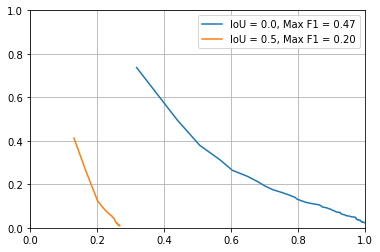

In [36]:
plt.plot(r_list, p_list, label=f'IoU = 0.0, Max F1 = {max(f_list):.2f}')
plt.plot(r_list_2, p_list_2, label=f'IoU = 0.5, Max F1 = {max(f_list_2):.2f}')
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.legend()
plt.grid()

In [22]:
with open('../../data/OpenImages/metadata-v4/class-names/class-descriptions.csv', 'r') as fin:
    mids = list(csv.reader(fin))
name2mid = {}
mid2name = {}
for item in mids:
    mid2name[item[0]] = item[1]
    name2mid[item[1].lower().replace(' ', '')] = item[0]


/home/alireza/home_at_filer2/tools/anaconda3/envs/py3torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


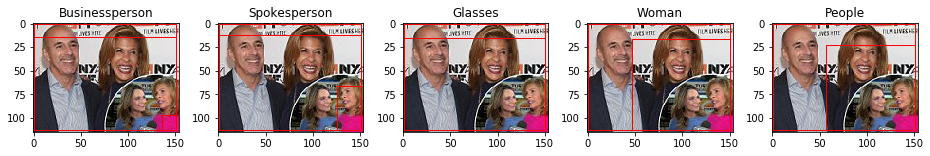

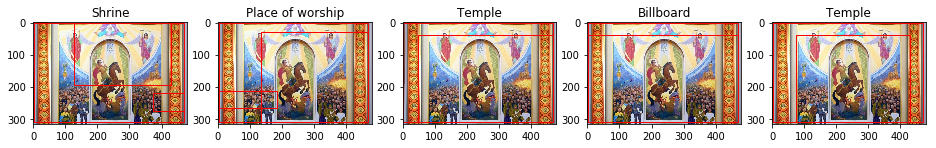

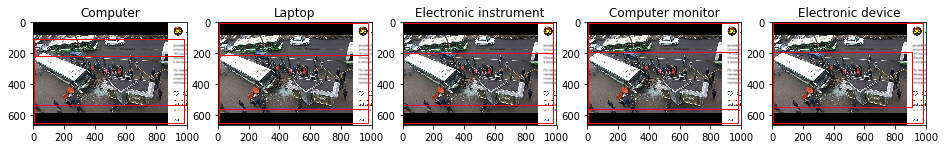

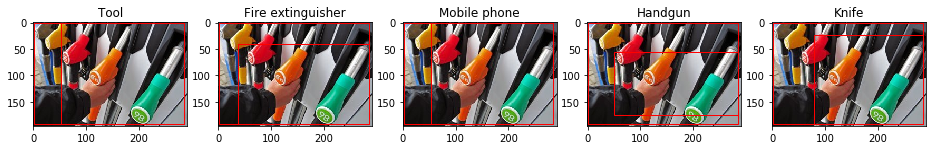

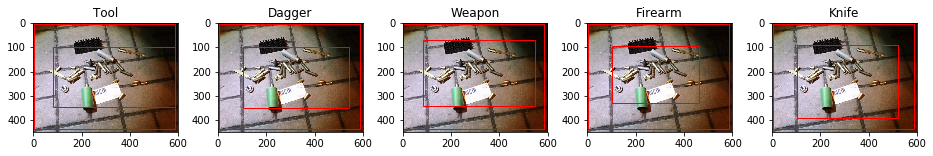

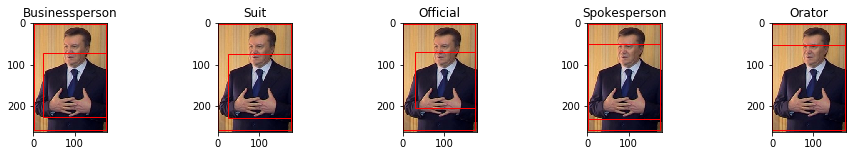

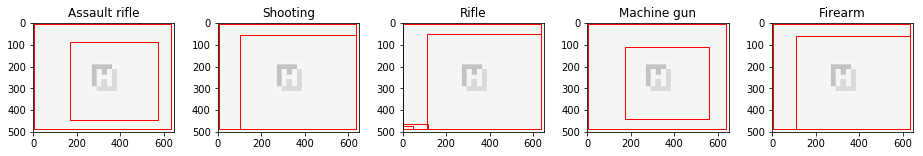

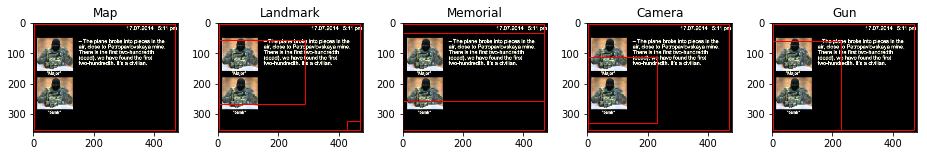

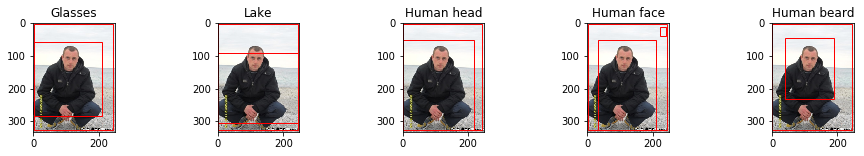

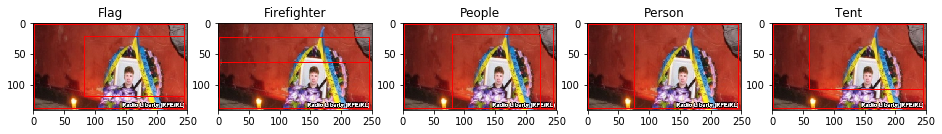

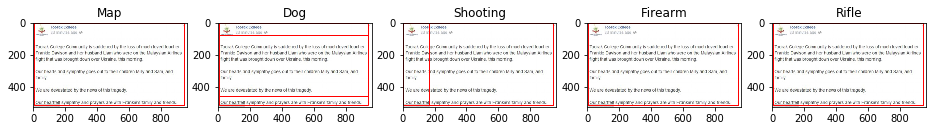

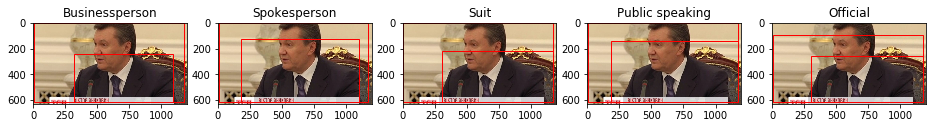

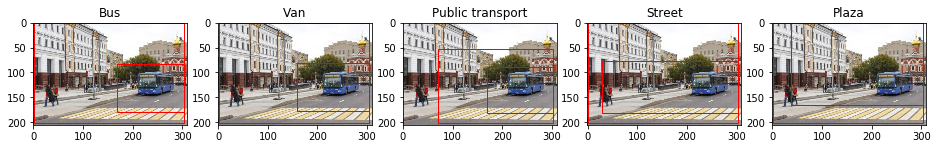

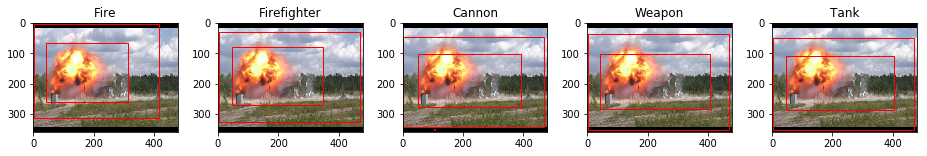

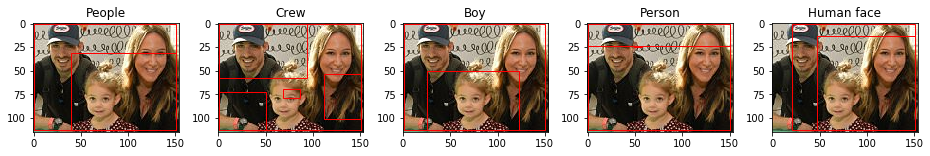

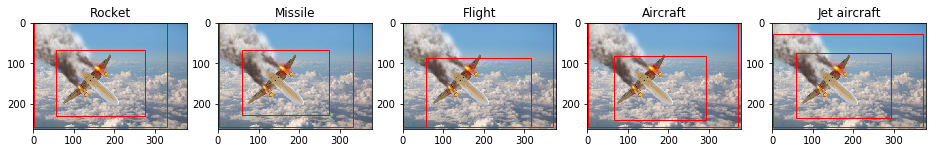

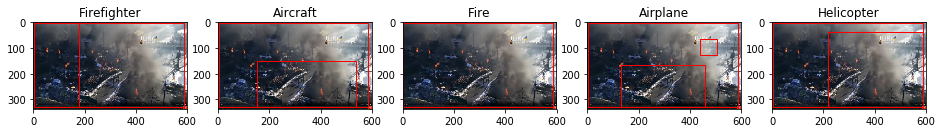

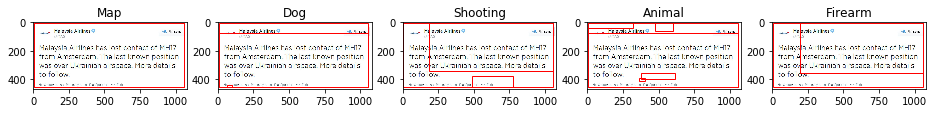

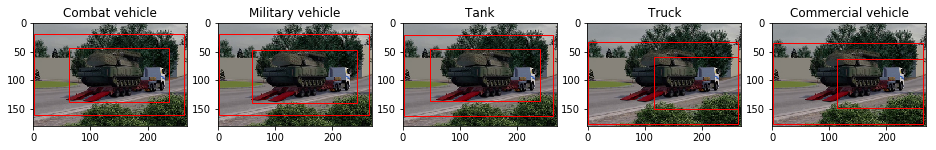

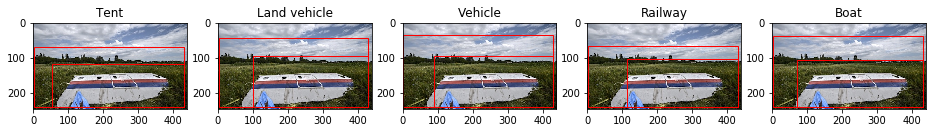

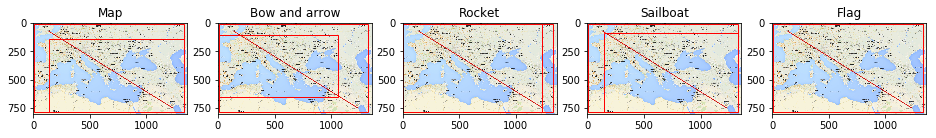

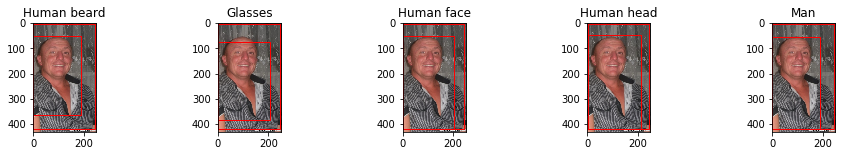

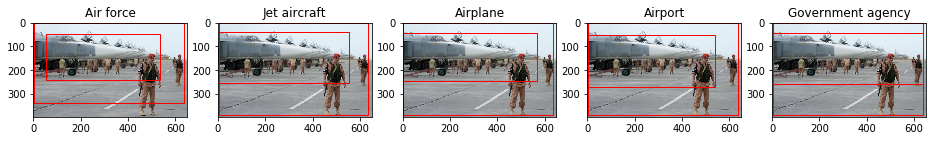

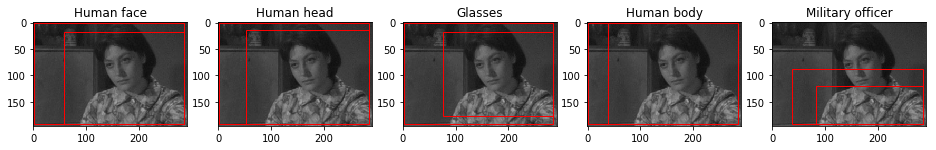

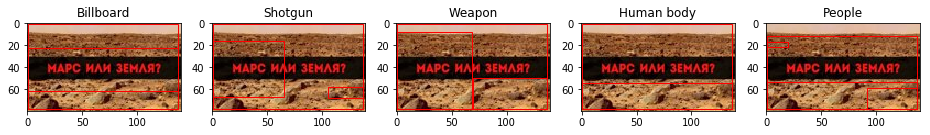

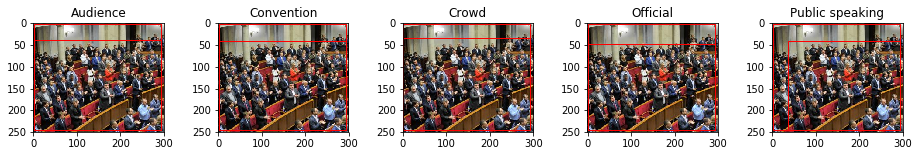

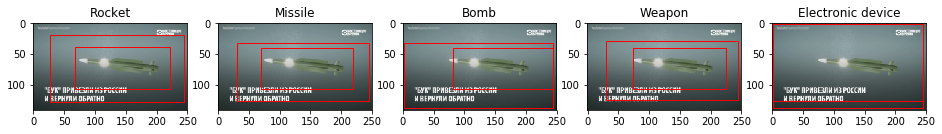

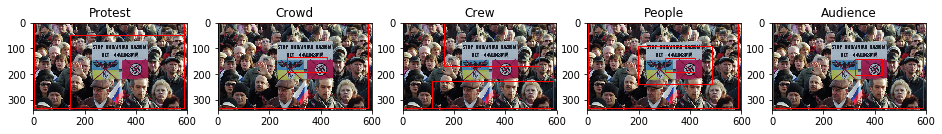

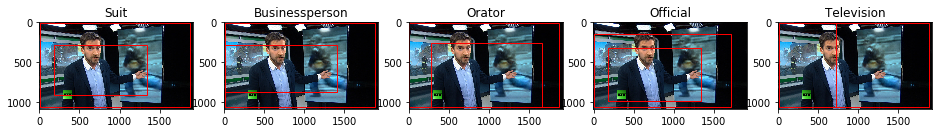

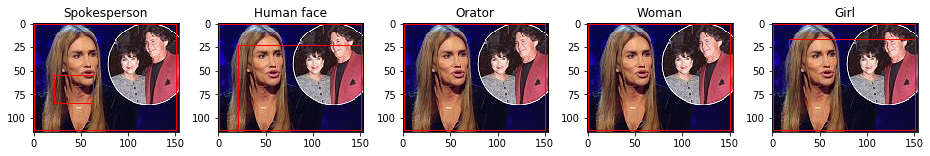

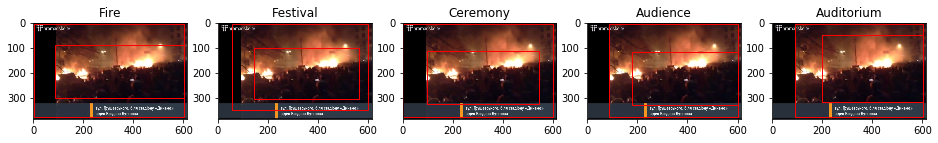

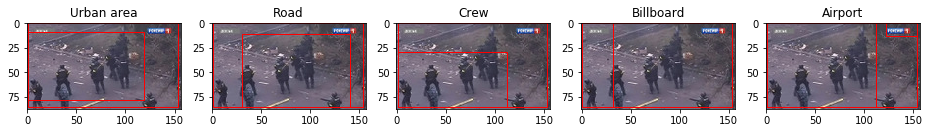

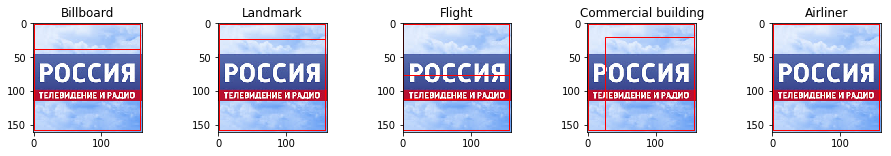

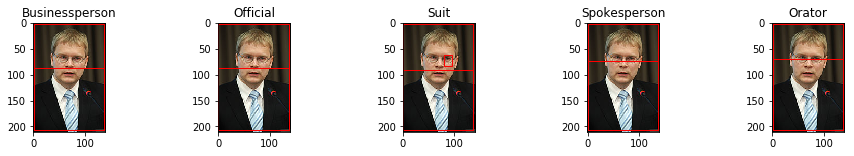

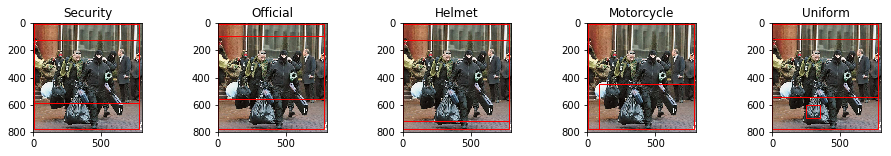

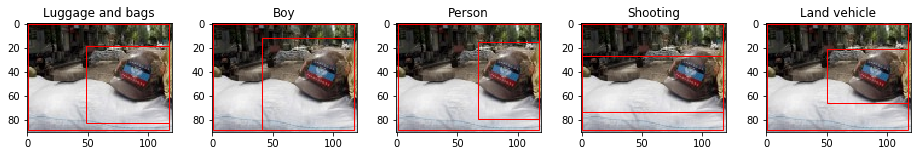

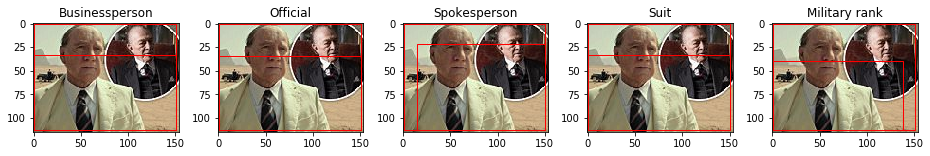

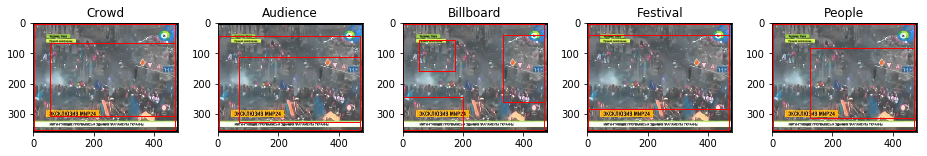

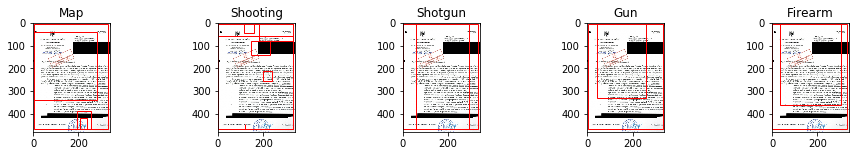

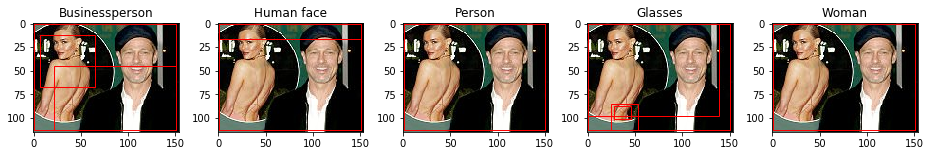

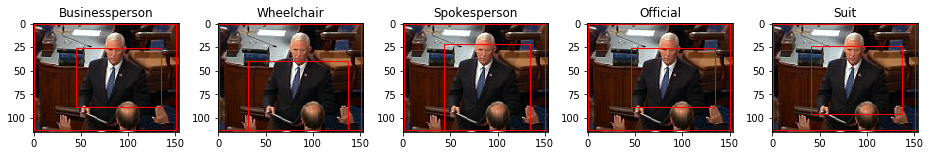

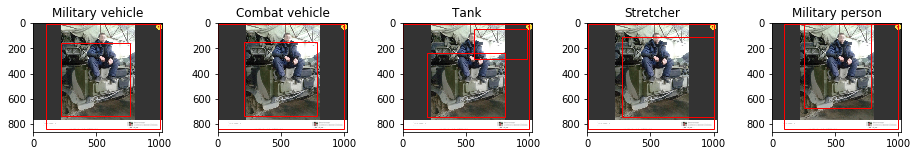

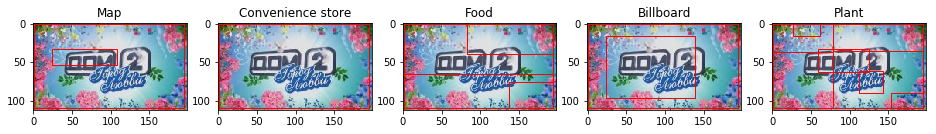

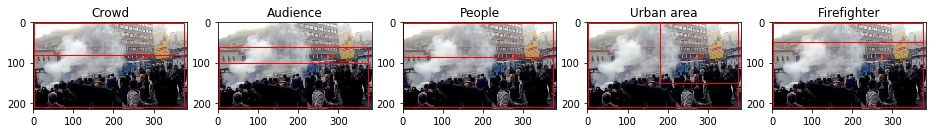

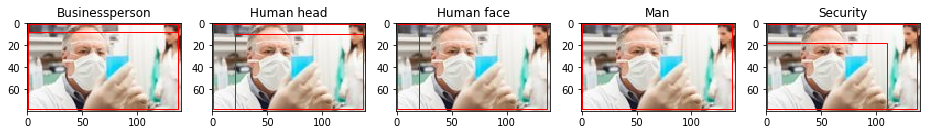

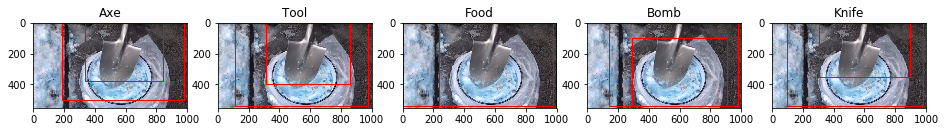

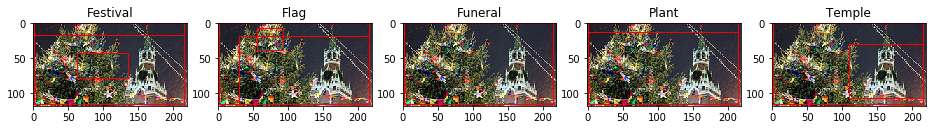

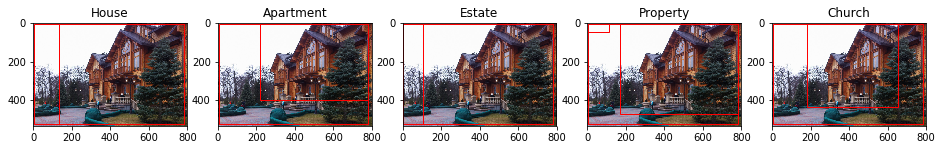

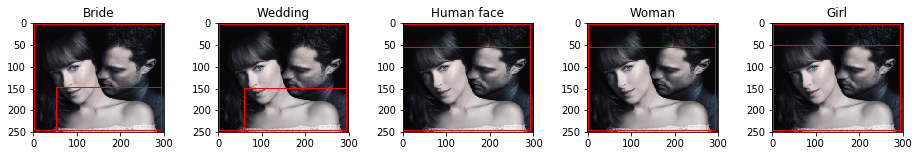

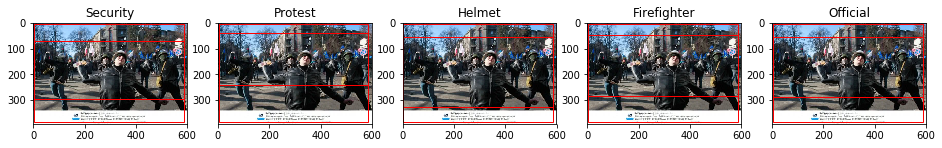

In [24]:
topk_vis = 5
for _ in range(50):
    filename = np.random.choice(test_img_filenames)
    imgid = filename.split('/')[-1]
    with open(filename, 'rb') as fin:
        _ = fin.read(1024)
        imgbin = fin.read()
    imgbgr = cv2.imdecode(np.fromstring(imgbin, dtype='uint8'), cv2.IMREAD_COLOR)
    imgrgb = imgbgr[:,:,[2,1,0]]        
    height, width, _ = imgrgb.shape

    #print([mid2name[item['label']] for item in annot[imgid]]) 
    
    fig, axes = plt.subplots(1, topk_vis, figsize=(16, 2))        
    
    for ii in range(topk_vis):
        axes[ii].imshow(imgrgb)
        axes[ii].set_title(mid2name[all_labels[det_results[imgid]['sorted_labels'][ii]]])
        for box in det_results[imgid]['sorted_bboxes'][ii]:
            axes[ii].add_patch(patches.Rectangle(
                (box[0]*width, box[1]*height), (box[2]-box[0])*width, (box[3]-box[1])*height,
                linewidth=1, edgecolor='r', facecolor='none'
            ))
            
    plt.show()